**Introduction to lmfit**


The lmfit module in Python provides a high-level interface for non-linear optimization and curve fitting. 
It builds on the capabilities of 'scipy.optimize' and offers several advantages:

- Easier management of parameters, including setting bounds and fixing values.
- Pre-defined models for common fitting functions.
- Tools for estimating uncertainties and goodness-of-fit.
- Facilities for performing more complex fits, including multi-dataset and constrained fitting.

In this notebook, we will demonstrate the basics of lmfit using a simple example of fitting a Gaussian function to noisy data.



In [3]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import lmfit 
from lmfit import Model

In [4]:
# Let's define the functions we will use to fit the data
def gaussian(x, amp, sig, cen):
    '''
    Gaussian distribution

    x - values for the fit
    a: amplitude of the line   --> defined as the inverse of the square root of 2pi times the variance (sigma**2)
    b: standard deviation      --> width of the distribution
    c: mean value              --> center of the distribution
    '''
    return amp*np.exp(-(x-cen)**2/(2*sig**2))

In [5]:
# Generate synthetic data with noise. We are going to create a Gaussian function, similarly to what emission lines look like
np.random.seed(0) # seed for reproducibility
x = np.linspace(0, 10, 100) # 100 points from 0 to 10

true_params = [2, 0.5, 5] # true parameters of the gaussian
y = gaussian(x, *true_params) + np.random.normal(0, 0.2, x.size) # generate the data with noise

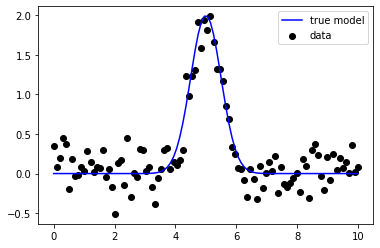

In [6]:
# Plot the data and the true model
plt.figure()
plt.scatter(x, y, color='k',label='data')
plt.plot(x, gaussian(x, *true_params),color='blue',label='true model')
plt.legend()
plt.show()

**Define the model to be fitted**

In [7]:
# Create a model object based on the gaussian function
model = Model(gaussian)
# You can access the parameters and other information of the model using the following attributes
print('The parameters of the model are:', model.param_names) # ['amp', 'sig', 'cen']
print('The independent variable of the model is:', model.independent_vars) # ['x']
print('The full information of the model is:', model.__dict__) 

The parameters of the model are: ['amp', 'sig', 'cen']
The independent variable of the model is: ['x']
The full information of the model is: {'func': <function gaussian at 0x7f9a745b9040>, '_prefix': '', '_param_root_names': ['amp', 'sig', 'cen'], 'independent_vars': ['x'], '_func_allargs': ['x', 'amp', 'sig', 'cen'], '_func_haskeywords': False, 'nan_policy': 'raise', 'opts': {}, 'independent_vars_defvals': {}, 'param_hints': {}, '_param_names': ['amp', 'sig', 'cen'], 'def_vals': {}, '_name': 'gaussian'}


In [8]:
# You can use predefined models from lmfit, like GaussianModel, LinearModel, QuadraticModel, etc.
model2 = lmfit.models.GaussianModel() # prefix='gmodel_' - you could add a prefix to the parameters if needed
# As it is a predefined model, you don't know the parameters beforehand, but you can access them using the following attribute
print(model2.param_names)

['amplitude', 'center', 'sigma']


In [9]:
# You can also use predefined models from astropy, like Gaussian1D, Linear1D, Moffat1D, etc.
import astropy.modeling.models as astropy_models
model3 = astropy_models.Gaussian1D()
print(model3.param_names) # ['amplitude', 'mean', 'stddev']

('amplitude', 'mean', 'stddev')


**Define the parameters for the fitting**

Before doing the fit, we need to show initialise the parameters that need to be fitted. 
In the case of a simple Gaussian, there will be just 3 parameters, the amplitude, the central value and the width. 

There are multiple ways to define the parameters, depending on the complexity of the model or on the constraints you may need to apply to them. 
This marks a difference with other fitting methods, such as "curve_fit" from scipy

The main constraints you can add are: 

     "value": initial value of the parameter

     "min"/"max": minimum and maximum boundaries allowed for the value of that parameter 

     "vary": (True/False, Default True) this indicates if you allow the model to vary or not the initial value of this parameter during the fit
     
     "expr": this parameter is evaluated following a matematical expresion indicated here, normally associated to another parameter. E.g. expr='a/3'

In [10]:
# Now there are several ways of initializing the parameters of the model
#-----------------------------------------------------------#
# 1. Initialize the parameters in a single line, without any other constraints
params = model.make_params(amp=1, sig=1, cen=dict(value=1, min=0))

# Define "a posteriori" constraints on each of the parameters. 
# How to define the bounds of the parameters
params['amp'].min = 0
# How to fix a parameter
params['cen'].vary = True
# How to set the initial value of a parameter
params['sig'].value = 0.5

# This method is useful when you have a simple model with few parameters
#-----------------------------------------------------------#
# 2. Define the parameters using the lmfit.Parameters() object
params = lmfit.Parameters()
params.add('amp', value=1)
params.add('sig', value=1, min=0, max=10, vary=True, expr=None)
params.add('cen', value=1, min=0)

# This method is useful when you have a more complex model with many parameters
#-----------------------------------------------------------#
# 3. Define the parameters using the lmfit.Parameter() object but adding them to the lmfit.Parameters() object
params = lmfit.Parameters()
a = lmfit.Parameter('amp', value=1,min=0)
b = lmfit.Parameter('sig', value=1,min=0)
c = lmfit.Parameter('cen', value=1,min=0)
params.add_many(a, b, c)

# This method is useful when you have a more complex model with many parameters.
# The advantage is in case you have several functions with the same parameters, 
# so you can reuse them and just define the parameters once.

**Fit the model to the data**

In [11]:
# Fit the model to the data
result = model.fit(y, params, x=x)
# If needed, you can also provide the params object directly
#result = model.fit(y, amp=1, sig=1, cen=1, x=x)
# If needed, you can also apply weights to the data
#result = model.fit(y, params, x=x, weights=1/np.sqrt(y))
# If needed, you can also apply bounds to the fit
#result = model.fit(y, params, x=x, bounds=(0, np.inf))
# If needed, you can also apply a method to the fit
#result = model.fit(y, params, x=x, method='leastsq')

# Print the result
print(result.fit_report())

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 68
    # data points      = 100
    # variables        = 3
    chi-square         = 3.94844536
    reduced chi-square = 0.04070562
    Akaike info crit   = -317.184826
    Bayesian info crit = -309.369316
    R-squared          = 0.86201193
[[Variables]]
    amp:  1.92640917 +/- 0.08490579 (4.41%) (init = 1)
    sig:  0.48268733 +/- 0.02456480 (5.09%) (init = 1)
    cen:  5.00915849 +/- 0.02456471 (0.49%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, sig) = -0.5773


In [12]:
# Show the results of the fit for each parameter
result.params.pretty_print()

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
amp     1.926        0      inf  0.08491     True     None     None
cen     5.009        0      inf  0.02456     True     None     None
sig    0.4827        0      inf  0.02456     True     None     None


In [13]:
# Extract and print individual parameter values and uncertainties
for name, param in result.params.items():
    print(f'{name}: {param.value} ± {param.stderr}')

amp: 1.926409174994864 ± 0.0849057942835112
sig: 0.4826873347091345 ± 0.02456480076983076
cen: 5.009158489422868 ± 0.024564705919859132


In [14]:
# Another way of doing it is by using Minimizer, but this method is for when you know the function that describes your data
# and you want to minimize the residuals. This is useful when you have a more complex model

# You would need to define the residuals function and the model function that you want to fit
'''
def residuals(params, x, y):
    return model(params, x) - y

# Perform fitting
result = lmfit.minimize(residuals, params, args=(x, y))
'''

'\ndef residuals(params, x, y):\n    return model(params, x) - y\n\n# Perform fitting\nresult = lmfit.minimize(residuals, params, args=(x, y))\n'

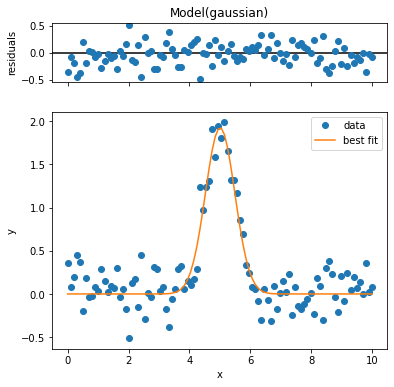

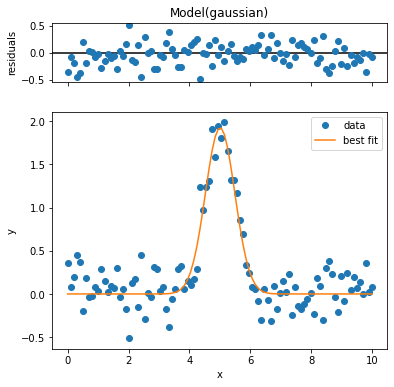

In [15]:
# Plot it using directly the lmfit.plot_fit() function
result.plot()

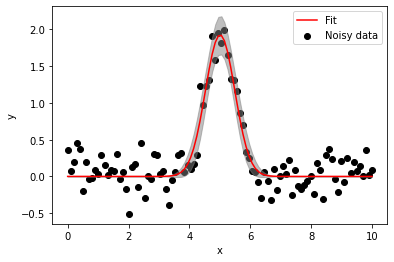

In [16]:
# We can evaluate the 3-sigma uncertainties of the fit using the eval_uncertainty() method
uncertainties = result.eval_uncertainty(sigma=3)

# Here we plot the fit with the uncertainties as a shaded region
plt.figure()
plt.scatter(x, y, color='k',label='Noisy data')
plt.plot(x, result.best_fit, color='red',label='Fit')
plt.fill_between(x, result.best_fit - uncertainties, result.best_fit + uncertainties, color='grey', alpha=0.5) 
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

**A more detailed way to estimate the errors of the fit**

Bootstrapping is a statistical method used to estimate the distribution of a statistic (e.g., mean, standard deviation) by resampling with replacement from the data. 
This technique is particularly useful when the theoretical distribution of the statistic is unknown or difficult to derive.

In [17]:
# Bootstrap resampling
n_bootstrap = 400
bootstrap_results = np.zeros((n_bootstrap, len(result.params)))

# Create new synthetic data n times based on the original data by randomly sampling with replacement
# Then fit the model to the new data and store the results
for i in range(n_bootstrap):
    sample_indices = np.random.choice(np.arange(y.size), size=y.size, replace=True)
    x_sample = x[sample_indices]
    y_sample = y[sample_indices]
    boot_result = model.fit(y_sample, params, x=x_sample)
    bootstrap_results[i, :] = [boot_result.params[p].value for p in result.params]

# Calculate means and standard deviations from bootstrap results
bootstrap_means = np.mean(bootstrap_results, axis=0)
bootstrap_stds = np.std(bootstrap_results, axis=0)

# Print bootstrap results vs the original results
for i, name in enumerate(result.params):
    print(f'{name} original: {result.params[name].value} ± {result.params[name].stderr}')
    print(f'{name} bootstrap: {bootstrap_means[i]} ± {bootstrap_stds[i]}')


amp original: 1.926409174994864 ± 0.0849057942835112
amp bootstrap: 1.7967228688998562 ± 0.46239617567220764
sig original: 0.4826873347091345 ± 0.02456480076983076
sig bootstrap: 0.48045849269354074 ± 0.09340786980652409
cen original: 5.009158489422868 ± 0.024564705919859132
cen bootstrap: 4.612005303472954 ± 1.3015948299604143


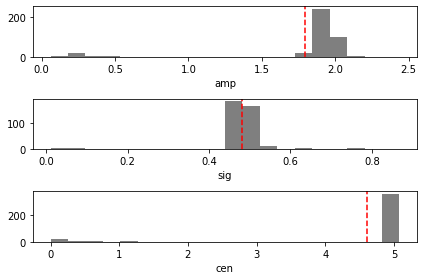

In [18]:
# Plot the bootstrap results as three subplots for each parameter
plt.figure()
for i, name in enumerate(result.params):
    plt.subplot(3, 1, i+1)
    plt.hist(bootstrap_results[:, i], bins=20, color='k', alpha=0.5)
    plt.axvline(bootstrap_means[i], color='r', linestyle='--')
    plt.xlabel(name)
plt.tight_layout()
plt.show()

**A more complex (and realistic) example...**

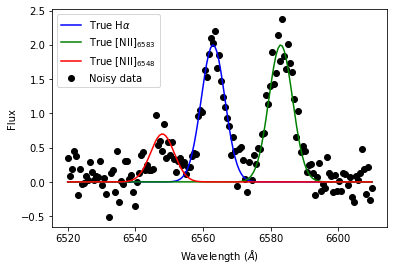

In [19]:
# Simulate the Halpha and [NII] emission lines, and fit them with a Gaussian model that is a sum of three Gaussians
# NII at 6548 and at 6583 Angstroms are related such that the ratio of their fluxes is 3:1
# Define the fake data
np.random.seed(0) # seed for reproducibility
x1 = np.linspace(6520, 6610, 150) # Wavelength range from 6530 to 6610 Angstroms 
true_params = [2, 3.5, 6563, 2, 3.5, 6583, 0.7, 3.5, 6548] # true parameters of the three Gaussians
y1 = gaussian(x1, *true_params[0:3]) + gaussian(x1, *true_params[3:6]) + gaussian(x1, *true_params[6:9]) + np.random.normal(0, 0.2, x1.size) # generate the data with noise

# Plot the data and the true model
plt.figure()
plt.scatter(x1, y1, color='k',label='Noisy data')
plt.plot(x1, gaussian(x1, *true_params[0:3]),color='blue',label=r'True H$\alpha$')
plt.plot(x1, gaussian(x1, *true_params[3:6]),color='green',label='True [NII]$_{6583}$')
plt.plot(x1, gaussian(x1, *true_params[6:9]),color='red',label='True [NII]$_{6548}$')
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Flux')
plt.legend()

In [20]:
# Define the model as the sum of the three Gaussians
model1 = lmfit.Model(gaussian) + lmfit.Model(gaussian) + lmfit.Model(gaussian)

NameError: 
Two models have parameters named 'cen'; use distinct names.
Two models have parameters named 'amp'; use distinct names.
Two models have parameters named 'sig'; use distinct names.

**The parameters need to be defined as they are named in the initial function, otherwise you will get a NameError**

In [21]:
# Define a three gaussian function with the a1, b1, c1, etc parameters
#def ThreeGaussian(x, a1, b1, c1, a2, b2, c2, a3, b3, c3):
#    return gaussian(x, a1, b1, c1) + gaussian(x, a2, b2, c2) + gaussian(x, a3, b3, c3)

# Or....
# You could use the same sigma for all the Gaussians
def ThreeGaussian(x, amp1, sig, cen1, amp2, cen2, amp3, cen3):
    return gaussian(x, amp1, sig, cen1) + gaussian(x, amp2, sig, cen2) + gaussian(x, amp3, sig, cen3)

# Create the model to the data using the ThreeGaussian function
model1 = Model(ThreeGaussian)

In [22]:
# Define the parameters with the same width for all the Gaussians
# The only conditions are same width for all the Gaussians and the ratio of the fluxes of the [NII] lines is 3:1
params1 = lmfit.Parameters()
a1 = lmfit.Parameter('amp1', value=1, min=0)
b1 = lmfit.Parameter('sig', value=1, min=0, vary=True)
c1 = lmfit.Parameter('cen1', value=6563., vary=True)
a2 = lmfit.Parameter('amp2', value=1, min=0)
c2 = lmfit.Parameter('cen2', value=6583., vary=True)
a3 = lmfit.Parameter('amp3', value=1, expr='amp2/3.')
c3 = lmfit.Parameter('cen3', value=6548., vary=True)
params1.add_many(a1, b1, c1, a2, c2, a3, c3)

In [23]:
# -----------------------------------------------------------#  
# Fit the model to the data using the ThreeGaussian function
model1 = Model(ThreeGaussian)

# Fit the model to the data
result1 = model1.fit(y1, params1, x=x1)

# Print the result
print(result1.fit_report())

# Show the results of the fit for each parameter
result1.params.pretty_print()

[[Model]]
    Model(ThreeGaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 150
    # variables        = 6
    chi-square         = 6.06496378
    reduced chi-square = 0.04211780
    Akaike info crit   = -469.216009
    Bayesian info crit = -451.152197
    R-squared          = 0.89909623
[[Variables]]
    amp1:  1.90898759 +/- 0.06955120 (3.64%) (init = 1)
    sig:   3.59777781 +/- 0.10567694 (2.94%) (init = 1)
    cen1:  6563.12071 +/- 0.16908141 (0.00%) (init = 6563)
    amp2:  2.06038285 +/- 0.06760691 (3.28%) (init = 1)
    cen2:  6583.13555 +/- 0.15598673 (0.00%) (init = 6583)
    amp3:  0.68679428 +/- 0.02253564 (3.28%) == 'amp2/3.'
    cen3:  6547.92547 +/- 0.47290220 (0.01%) (init = 6548)
[[Correlations]] (unreported correlations are < 0.100)
    C(sig, amp2)  = -0.4630
    C(amp1, sig)  = -0.4174
    C(amp1, amp2) = +0.1899
    C(sig, cen3)  = -0.1068
Name     Value      Min      Max   Stderr     Vary     Expr Bru

In [24]:
# Print the fluxes of the [NII] lines and estimate the ratio
flux_NII_6548 = result1.params['amp3'].value
flux_NII_6583 = result1.params['amp2'].value
ratio = flux_NII_6548/flux_NII_6583
print(f'Ratio of [NII] 6548 to [NII] 6583: {ratio}')
print(1/3)

Ratio of [NII] 6548 to [NII] 6583: 0.33333333333333337
0.3333333333333333


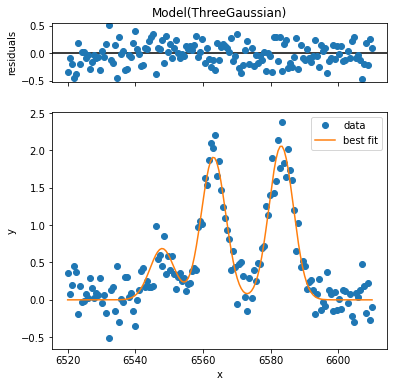

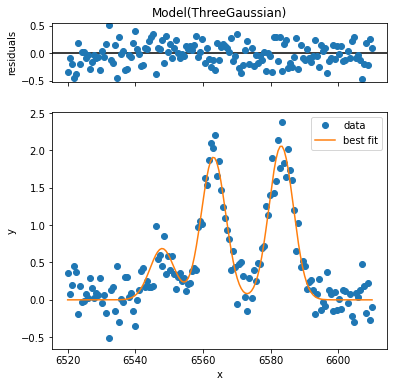

In [25]:
# Plot the results
result1.plot()

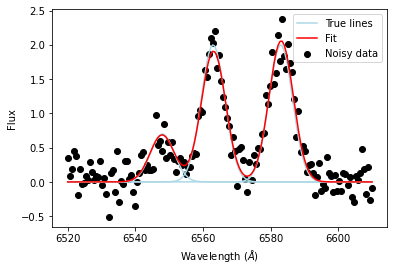

In [26]:
# Compare the results of the fit with the true parameters
plt.figure()
plt.scatter(x1, y1, color='k',label='Noisy data')
plt.plot(x1, gaussian(x1, *true_params[0:3]),color='lightblue',label='True lines')
plt.plot(x1, gaussian(x1, *true_params[3:6]),color='lightblue')
plt.plot(x1, gaussian(x1, *true_params[6:9]),color='lightblue')
plt.plot(x1, result1.best_fit, color='red',label='Fit')
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Flux')
plt.legend()


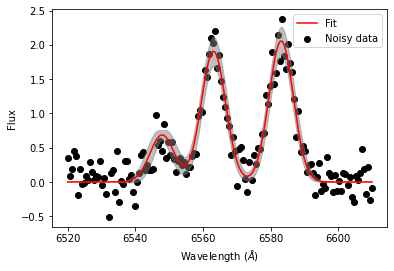

In [27]:
# We can evaluate the 3-sigma uncertainties of the fit using the eval_uncertainty() method
uncertainties = result1.eval_uncertainty(sigma=3)

# Here we plot the fit with the uncertainties as a shaded region
plt.figure()
plt.scatter(x1, y1, color='k',label='Noisy data')
plt.plot(x1, result1.best_fit, color='red',label='Fit')
plt.fill_between(x1, result1.best_fit - uncertainties, result1.best_fit + uncertainties, color='grey', alpha=0.5) 
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Flux')
plt.legend()
plt.show()
